### 导入相关需要的库

In [1]:
from core.data_processor import DataLoader
import pandas as pd
import json
from core.model import Model
import matplotlib.pyplot as plt

In [2]:
from numpy import set_printoptions
set_printoptions(suppress=True)

#### 画图（可视化函数）

In [3]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data)
    # 填充预测列表，将其在图表中移动到正确的开始位置
    for i, data in enumerate(predicted_data):
        padding = [None for _ in range(i * prediction_len)]
        plt.plot(padding + data)
    plt.show()

#### * 1.导入设置文件和数据

In [4]:
configs = json.load(open('config.json', 'r'))
df = pd.read_csv('./data/sh600031.csv')  # 读取股票文件

In [5]:
df.head()

,date,open,high,low,close,volume
0,2003-07-03,23.00,23.00,20.10,21.30,33816715
1,2003-07-04,21.30,22.18,21.05,21.84,7697544
2,2003-07-07,21.90,21.96,21.51,21.80,3951205
3,2003-07-08,21.80,22.22,21.70,21.91,2117357
4,2003-07-09,21.75,22.65,21.70,22.47,3440447


In [6]:
df.shape

(4424, 6)

#### * 2.用DataLoader加载数据df，它将会安装预先设置好的‘train_test_split’和‘columns’对数据进行分割和采样

In [7]:
data = DataLoader(
        dataframe=df,
        split=configs['data']['train_test_split'],
        cols=configs['data']['columns']
    )

     * 2.1 加载训练集，数据采用滑动窗口的方式采样：
     按照‘sequence_length’序列长度对数据进行滑动窗口的方式采样：即第n+1个点数据+前n个点数据=sequence_length

In [8]:
x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    * 2.2 加载训练集，数据采用滑动窗口的方式采样

In [9]:
x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

In [10]:
x.shape,y.shape

((3745, 14, 2), (3745, 1))

In [11]:
x_test.shape,y_test.shape

((649, 14, 2), (649, 1))

#### * 3.构建模型

In [12]:
model = Model()
model.build_model(configs, x.shape[1], x.shape[2])

[Model] Model Compiled
Time taken: 0:00:01.452305


#### * 4.进行训练 

In [13]:
# 内存中训练
model.train(
    x,
    y,
    epochs=configs['training']['epochs'],
    batch_size=configs['training']['batch_size'],
    validation_data=(x_test, y_test),
    verbose=configs['training']['verbose'],
    shuffle=configs['training']['shuffle'],
    validation_freq=configs['training']['validation_freq'],
    save_dir=configs['model']['save_dir']
)

[Model] Training Started
[Model] 32 epochs, 64 batch size
Epoch 1/32
59/59 [==============================] - 17s 153ms/step - loss: 0.0096 - val_loss: 0.0030
Epoch 2/32
59/59 [==============================] - 7s 119ms/step - loss: 0.0055 - val_loss: 0.0022
Epoch 3/32
59/59 [==============================] - 7s 112ms/step - loss: 0.0042 - val_loss: 0.0017
Epoch 4/32
59/59 [==============================] - 7s 116ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 5/32
59/59 [==============================] - 7s 122ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 6/32
59/59 [==============================] - 8s 128ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 7/32
59/59 [==============================] - 7s 118ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 8/32
59/59 [==============================] - 7s 118ms/step - loss: 0.0023 - val_loss: 9.3241e-04
Epoch 9/32
59/59 [==============================] - 7s 123ms/step - loss: 0.0021 - val_loss: 8.7964e-04
Epoch 10/32
59/59 [==============

In [14]:
# 多序列预测
predictions_multiseq = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'],
                                                        configs['data']['sequence_length'])

# 全系列预测
predictions_fullseq = model.predict_sequence_full(x_test, configs['data']['sequence_length'])

# 逐点预测
predictions_pointbypoint = model.predict_point_by_point(x_test)

[Model] Predicting Sequences Multiple...
[Model] Predicting Sequences Full...
[Model] Predicting Point-by-Point...


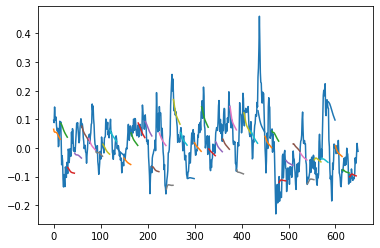

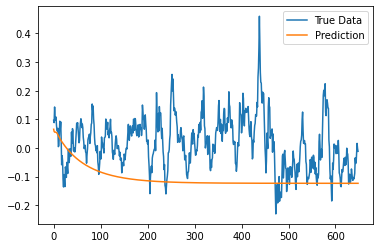

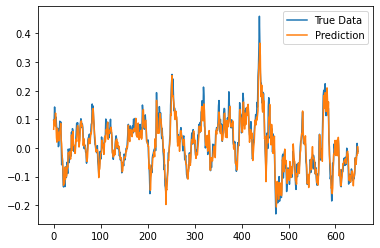

In [15]:
# 画图
plot_results_multiple(predictions_multiseq, y_test, configs['data']['sequence_length'])
plot_results(predictions_fullseq, y_test)
plot_results(predictions_pointbypoint, y_test)